<a href="https://colab.research.google.com/github/schauppi/Udemy_TensorFlow_Developer/blob/main/Abschnitt_6_Transfer_Learning/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Leaning in TensorFlow Part 2: Fine-tuning


In [1]:
!nvidia-smi

Wed Jul 21 12:08:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-07-21 12:08:33--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-07-21 12:08:33 (76.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
#Import helper functions we´re going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let´s get some data

This time weé going to see how we can use the pretrained models with tf.keras.applications ans apply them to out own problem.

In [4]:
#get 10% of training data from 10_food_classes_10_percent
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2021-07-21 12:08:35--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 172.253.117.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   201MB/s    in 0.8s    

2021-07-21 12:08:36 (201 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
#Unzip data using the helper function
unzip_data("10_food_classes_10_percent.zip")

In [6]:
#Check out how many images and subdirectories are in our dataset 
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [7]:
#Create training an test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

IMG_SIZE = (224,224)
BATCH_SIZE=32
train_data_10_percent = image_dataset_from_directory(train_dir,
                                                     image_size=IMG_SIZE,
                                                     label_mode="categorical",
                                                     batch_size=BATCH_SIZE)

test_data_10_percent = image_dataset_from_directory(test_dir,
                                                    image_size=IMG_SIZE,
                                                    label_mode="categorical",
                                                    batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [10]:
#Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
#see an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[1.38484695e+02 1.24229591e+02 1.24357140e+02]
   [1.37551025e+02 1.25474495e+02 1.27500008e+02]
   [1.41642853e+02 1.30642853e+02 1.37071426e+02]
   ...
   [1.36806229e+02 7.66633682e+01 7.10919342e+01]
   [1.23571205e+02 7.72651825e+01 6.48824997e+01]
   [8.62853622e+01 5.75712547e+01 3.92854691e+01]]

  [[1.33163269e+02 1.16306122e+02 1.16331627e+02]
   [1.33005096e+02 1.17852043e+02 1.20714287e+02]
   [1.35816330e+02 1.23244896e+02 1.30459183e+02]
   ...
   [9.15152588e+01 5.30867348e+01 5.65152817e+01]
   [7.96835403e+01 5.30356674e+01 5.03111496e+01]
   [5.42649956e+01 4.33110542e+01 3.53110161e+01]]

  [[1.42214294e+02 1.21928574e+02 1.23071426e+02]
   [1.40397949e+02 1.24183678e+02 1.27112251e+02]
   [1.40928558e+02 1.28188782e+02 1.35739792e+02]
   ...
   [5.83366356e+01 4.21683273e+01 5.07397346e+01]
   [5.45663376e+01 4.67398682e+01 5.04082108e+01]
   [5.12038918e+01 5.11376457e+01 5.01376076e+01]]

  ...

  [[7.41377640e+01 3.99948845e+01 2.08571262e+01]
   [6

## Model 0: Building a transfer learning model using the Keras Functional API

In [12]:
#1. Create a base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (the underlying pre-trained patterns aren´t updated during training)
base_model.trainable = False

# 3. Create inputs into out model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# 4. If using a model like ResNet50V2 you will need to normalize inputs (don´t needed for EfficientNets)
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(optimizer="Adam", metrics=["accuracy"], loss="categorical_crossentropy")

# 10. Fit the model
history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data_10_percent,
                        validation_steps=int(0.25 * len(test_data_10_percent)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="10_percent_feature_extraction")])

16711680/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20210721-120848
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 42s 308ms/step - loss: 1.9360 - accuracy: 0.3560 - val_loss: 1.3696 - val_accuracy: 0.6760
Epoch 2/5
24/24 [==============================] - 5s 202ms/step - loss: 1.1712 - accuracy: 0.7267 - val_loss: 0.8988 - val_accuracy: 0.8191
Epoch 3/5
24/24 [==============================] - 5s 207ms/step - loss: 0.8626 - accuracy: 0.8013 - val_loss: 0.7171 - val_accuracy: 0.8503
Epoch 4/5
24/24 [==============================] - 5s 210ms/step - loss: 0.7032 - accuracy: 0.8387 - val_loss: 0.6262 - val_accuracy: 0.8586
Epoch 5/5
24/24 [==============================] - 5s 209ms/step - loss: 0.6040 - accuracy: 0.8453 - val_loss: 0.5623 - val_accuracy: 0.8750


In [13]:
# Evaluate on the full test dataset 
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 9s 110ms/step - loss: 0.6184 - accuracy: 0.8472


[0.6183578372001648, 0.8471999764442444]

In [14]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [15]:
# Get a summary of the base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [16]:
# Summary of whole model
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


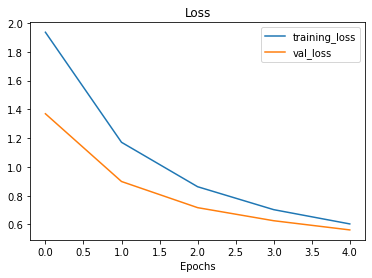

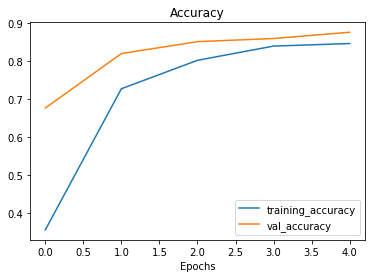

In [17]:
# Check out our models´2 training curves
plot_loss_curves(history_0)

## Getting a feature vector from a trained model

Let´s demonstrate the Global Average Pooling 2D layer..

We have a tensor ofter our model goes through base_model of shape (None, 7, 7, 1289)...

After GlobalAveragePooling2D it turns into (None, 1280).

Let´s use a tensor of shape (1,4,4,3=´) and then pass it to Global Average Pooling 2D)

In [18]:
# Define the input shape
input_shape = (1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor: \n {input_tensor}\n")

# Pass the random tensor through a random global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of the input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor: 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of the input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [19]:
# Let´s replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a series of transfer learning experiments

Experiments:

1. model_1 - use feature extraction transfer learning with 1% of the training data with data augmentation
2. model_2 - use feature extraction transfer learning with 10% of the training with data augmentation
3. model_3 - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. model_4 - use fine-tuning transfer learning on 100% of the training data with data augmentation

## Getting and preprocessing data for model_1

In [20]:
# Download and unzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2021-07-21 12:10:15--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 172.253.117.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   219MB/s    in 0.6s    

2021-07-21 12:10:16 (219 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [21]:
#Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [22]:
#How many images?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There a

In [23]:
#Setup data loaders
IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

* tf.keras.layers.experimental.preprocessing()

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#Create data augmentation stage
data_augmentation = keras.Sequential([
                                      preprocessing.RandomFlip("horizontal"),
                                      preprocessing.RandomRotation(0.2),
                                      preprocessing.RandomZoom(0.2),
                                      preprocessing.RandomHeight(0.2),
                                      preprocessing.RandomWidth(0.2),
], name="data_augmentation")

### Visualize our data augmentation layer (and see what happens to our data)

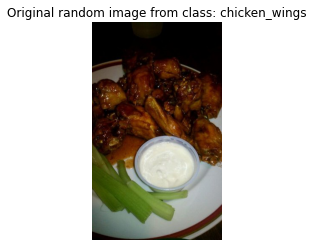

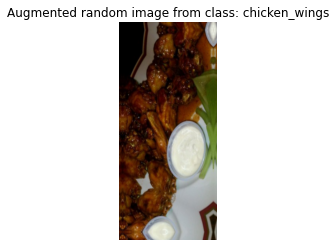

In [26]:
#View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimp
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

#Read in the random image
img = mpimp.imread(random_image_path)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False)
plt.imshow(img)

# Now let´s plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False)
plt.imshow(tf.squeeze(augmented_img)/255.)

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [31]:

# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data=test_data,
                    validation_steps=int(0.25* len(test_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20210721-122800
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


3/3 [==============================] - 11s 3s/step - loss: 2.3798 - accuracy: 0.1000 - val_loss: 2.2172 - val_accuracy: 0.1875
Epoch 2/5
3/3 [==============================] - 4s 1s/step - loss: 2.0841 - accuracy: 0.3286 - val_loss: 2.0979 - val_accuracy: 0.2681
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 2.0090 - accuracy: 0.3857 - val_loss: 1.9971 - val_accuracy: 0.3388
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.7673 - accuracy: 0.5857 - val_loss: 1.9002 - val_accuracy: 0.4046
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6040 - accuracy: 0.7143 - val_loss: 1.8321 - val_accuracy: 0.4622


In [32]:
#Check out a model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [34]:
#Evaluate on the full test data set 
results_1_percent_data_aug = model_1.evaluate(test_data)

79/79 [==============================] - 9s 104ms/step - loss: 1.8109 - accuracy: 0.4784


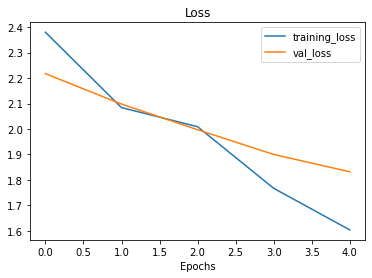

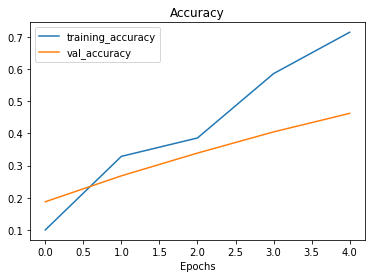

In [36]:
# How do the model with 1% of the data augmentation loss curves look like?
plot_loss_curves(history_1_percent)

## Model 2: feature extraction transfer learning model with 10% of data and data augmentation

In [41]:
#get 10 percent of data
train_data_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [44]:
#How many images in directory?
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [42]:
#Set data inputs
import tensorflow as tf
IMG_SIZE = (224,224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_data_10_percent, 
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [51]:
#Create model 2 with data augmentation build in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

#Build data augmentation layer
data_augmentation = Sequential([
                                preprocessing.RandomFlip("horizontal"),
                                preprocessing.RandomHeight(0.2),
                                preprocessing.RandomWidth(0.2),
                                preprocessing.RandomZoom(0.2),
                                preprocessing.RandomRotation(0.2)
],name="data_augmentation")

#Setup the inpur shape to our model
input_shape = (224,224,3)

#Create a frozen base model (backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#Create the inputs and outputs 
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation="softmax")(x)

#Make the model with inputs and outputs
model_2 = keras.Model(inputs, outputs)

#Compile the model
model_2.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [52]:
model_2.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_2D (G (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


### Creating a model checkpoint callback

The ModelCheckpoint callback intermediately saves our model (the full model or just the wheights) during training. This is useful so we can come and start where we left off.

In [54]:
#Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

#Create a ModelCheckpoint callback that saves the model´s weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                         save_weights_only=True, 
                                                         save_best_only=False, 
                                                         save_freq="epoch" #save ebery epoch
                                                         ,verbose=1)

### Fit model 2 passing in the ModelCheckpoint callback

In [55]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          steps_per_epoch=len(train_data_10_percent),
                                          validation_data = test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"), checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20210721-130924
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 19s 575ms/step - loss: 2.0680 - accuracy: 0.3000 - val_loss: 1.5295 - val_accuracy: 0.6332

Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 10s 419ms/step - loss: 1.4036 - accuracy: 0.6547 - val_loss: 1.1016 - val_accuracy: 0.7434

Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 11s 429ms/step - loss: 1.1026 - accuracy: 0.7240 - val_loss: 0.8769 - val_accuracy: 0.7812

Epoch 00003: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 10s 397ms/step - loss: 0.9341 - accuracy: 0.7640 - val_loss: 0.7957 - val_accuracy: 0.7845

Epoch 00004: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 5/5
24/24 [==============================] - 9s 376ms/step - loss: 0.8293 - accuracy: 0.7840 - val_l

79/79 [==============================] - 9s 107ms/step - loss: 0.7014 - accuracy: 0.8180


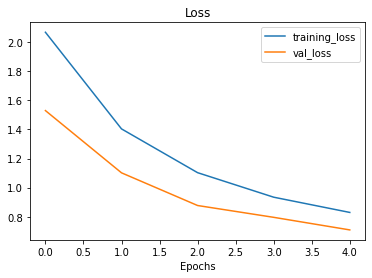

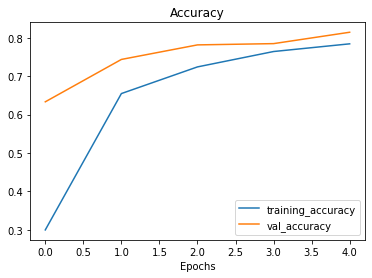

In [57]:
results_10_percent_data_aug = model_2.evaluate(test_data)
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights

In [58]:
# Load in saved model weights and evaluate model
print(checkpoint_path)
model_2.load_weights(checkpoint_path)

#Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

ten_percent_model_checkpoints_weights/checkpoint.ckpt
79/79 [==============================] - 9s 109ms/step - loss: 0.7014 - accuracy: 0.8180


In [60]:
# Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [61]:
#Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[-1.78813934e-07  0.00000000e+00]


## Model 3: Fine-tuning an existing model on 10 percent of the data

Fine-tuning usually works best after training a feature extraction model for a few epochs with a large amount of custom data.

Model 3 is a fine tuned version of Model 2

In [62]:
#Layers in loaded model
model_2.layers

In [64]:
#Are these layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fc29a06c2d0> True
<tensorflow.python.keras.engine.sequential.Sequential object at 0x7fc29a02e110> True
<tensorflow.python.keras.engine.functional.Functional object at 0x7fc297e369d0> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7fc297dfadd0> True
<tensorflow.python.keras.layers.core.Dense object at 0x7fc297d9c710> True


In [65]:
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer, layer.name, layer.trainable)

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fc29a07d190> input_6 False
1 <tensorflow.python.keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fc29a08f850> rescaling_5 False
2 <tensorflow.python.keras.layers.preprocessing.normalization.Normalization object at 0x7fc29a0221d0> normalization_5 False
3 <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7fc29a08fd10> stem_conv_pad False
4 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc29a51fbd0> stem_conv False
5 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fc29a4822d0> stem_bn False
6 <tensorflow.python.keras.layers.core.Activation object at 0x7fc29a022d10> stem_activation False
7 <tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x7fc29a055c50> block1a_dwconv False
8 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fc29a0552d0> block1a_bn False
9 <tensorflow.python

In [66]:
#How many trainable variables in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [74]:
#To begin fine-tuning, let´s start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

#Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

#Recompile (we have tp recompile our models every time we make a change)
model_2.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])

In [75]:
#Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_6 False
1 rescaling_5 False
2 normalization_5 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [76]:
#Now we´ve unfrozen some of the layers closer to the top, how many trainable variables are in our model?
print(len(model_2.trainable_variables))

12


In [78]:
#Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

#Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_augt = model_2.fit(train_data_10_percent,
                                                epochs=fine_tune_epochs,
                                                validation_data=test_data,
                                                validation_steps=int(0.25 * len(test_data)),
                                                initial_epoch=history_10_percent_data_aug.epoch[-1] #start training from the previous last epoch
                                                ,callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20210721-135143
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 20s 545ms/step - loss: 0.7009 - accuracy: 0.8133 - val_loss: 0.5574 - val_accuracy: 0.8306
Epoch 6/10
24/24 [==============================] - 10s 397ms/step - loss: 0.5606 - accuracy: 0.8333 - val_loss: 0.5183 - val_accuracy: 0.8207
Epoch 7/10
24/24 [==============================] - 9s 354ms/step - loss: 0.5254 - accuracy: 0.8400 - val_loss: 0.5279 - val_accuracy: 0.8092
Epoch 8/10
24/24 [==============================] - 9s 360ms/step - loss: 0.4481 - accuracy: 0.8680 - val_loss: 0.5313 - val_accuracy: 0.8174
Epoch 9/10
24/24 [==============================] - 9s 373ms/step - loss: 0.3934 - accuracy: 0.8947 - val_loss: 0.5352 - val_accuracy: 0.8174
Epoch 10/10
24/24 [==============================] - 9s 361ms/step - loss: 0.3899 - accuracy: 0.8867 - val_loss: 0.5077 - val_accuracy: 0.8207


In [79]:
# Evaluate the fine-tuned model (model_3 which is actually model_2 fine-tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 9s 104ms/step - loss: 0.4899 - accuracy: 0.8352
